In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

2023-06-26 07:47:49.992586: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "./dataset_2/training"
val_path = "./dataset_2/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-26 07:47:52.009968: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 07:47:52.747790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7910 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Found 11289 files belonging to 3 classes.
Found 2823 files belonging to 3 classes.


In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


### Test set

In [8]:
with tf.device("CPU"):
    # Buffered prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = val_ds.prefetch(buffer_size = AUTOTUNE)

In [ ]:
print(len(validation_dataset))
print(len(test_dataset))

## Model building

In [40]:
def lenet(dropout_num):
    model = Sequential([
    Conv2D(2, (3, 3), activation='relu', input_shape=img_shape),
    Dropout(dropout_num),
    MaxPooling2D((2, 2)),
        
    Conv2D(4, (3, 3), activation='relu'),
    Dropout(dropout_num),
    MaxPooling2D((2, 2)),
    MaxPooling2D((2, 2)),   
        
    Flatten(),
    Dense(4, activation='relu'),
    Dense(4, activation='relu'),
#     Dropout(dropout_num),
    Dense(3, activation='softmax')
])
    return model

In [41]:
with tf.device("GPU"):
    model = lenet(0.2)

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 182, 214, 2)       56        
                                                                 
 dropout_24 (Dropout)        (None, 182, 214, 2)       0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 91, 107, 2)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 89, 105, 4)        76        
                                                                 
 dropout_25 (Dropout)        (None, 89, 105, 4)        0         
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 44, 52, 4)        0         
 g2D)                                                 

## Model training

In [23]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn1_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [43]:
EPOCH = 100

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/100
353/353 [==============================] - 4s 10ms/step - loss: 1.0980 - accuracy: 0.3518 - val_loss: 1.1042 - val_accuracy: 0.3110
Epoch 2/100
353/353 [==============================] - 4s 10ms/step - loss: 1.0648 - accuracy: 0.4232 - val_loss: 1.1157 - val_accuracy: 0.3510
Epoch 3/100
353/353 [==============================] - 4s 10ms/step - loss: 1.0122 - accuracy: 0.4853 - val_loss: 1.1345 - val_accuracy: 0.3656
Epoch 4/100
353/353 [==============================] - 4s 10ms/step - loss: 0.9708 - accuracy: 0.5254 - val_loss: 1.1593 - val_accuracy: 0.3567
Epoch 5/100
353/353 [==============================] - 4s 10ms/step - loss: 0.9288 - accuracy: 0.5625 - val_loss: 1.1701 - val_accuracy: 0.3936
Epoch 6/100
353/353 [==============================] - 4s 10ms/step - loss: 0.8986 - accuracy: 0.5857 - val_loss: 1.1982 - val_accuracy: 0.3826
Epoch 7/100
353/353 [==============================] - 4s 10ms/step - loss: 0.8766 - accuracy: 0.6044 - val_loss: 1.2186 - val_accuracy:

### Training evaluation

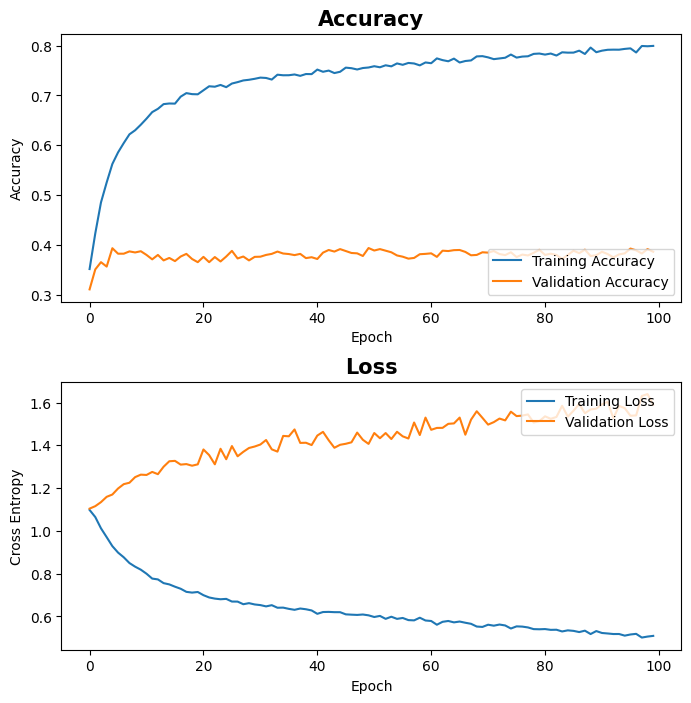

In [44]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')

plt.subplots_adjust(hspace=0.3)
plt.show()